<a href="https://colab.research.google.com/github/libra3910/diveintocode-ml/blob/master/scratch_deep_learning_FrameWork1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# sprint ディープラーニングフレームワーク１

## 【問題１】スクラッチを振り返る
### ここまでのスクラッチを振り返り、ディープラーニングを実装するためにはどのようなものが必要だったかを列挙してください。
```py
①勾配降下法を使用した目的関数の最小化ロジックの実装
②重みとバイアスの初期値設定に乱数の生成
③重みとバイアスの更新ロジックの記述
④学習率の設定
⑤バッチ数ごとの読み取り
```

### 【問題２】スクラッチとTensorFlowの対応を考える

### 「ディープラーニングを実装するために必要なもの」がTensorFlowではどう実装されているかを確認

```py
①目的関数の最小化ロジックはtf.nn.softmax_cross_entropy_with_logitsを使用。
②重みとバイアスはvariableとして用意。
③重みとバイアスは、最適化手法（optimizer.minimize）により更新される。
④学習率は最適化手法（optimizer）で使用する。
⑤ミニバッチで分割した学習データを最適化手法により学習させる。
⑥推定結果、指標値計算はTensowFlowを使用する。
```

### 【問題3】3種類全ての目的変数を使用したIrisのモデルを作成

In [1]:
!pip install --upgrade tensorflow==1.13.2

Requirement already up-to-date: tensorflow==1.13.2 in /usr/local/lib/python3.7/dist-packages (1.13.2)


In [2]:
pip list

Package                       Version       
----------------------------- --------------
absl-py                       0.10.0        
alabaster                     0.7.12        
albumentations                0.1.12        
altair                        4.1.0         
appdirs                       1.4.4         
argon2-cffi                   20.1.0        
asgiref                       3.3.1         
astor                         0.8.1         
astropy                       4.2           
astunparse                    1.6.3         
async-generator               1.10          
atari-py                      0.2.6         
atomicwrites                  1.4.0         
attrs                         20.3.0        
audioread                     2.1.9         
autograd                      1.3           
Babel                         2.9.0         
backcall                      0.2.0         
beautifulsoup4                4.6.3         
bleach                        3.3.0         
blis      

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import math
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [4]:
from sklearn.datasets import load_iris
data = load_iris()

In [5]:
x = pd.DataFrame(data = data.data, columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])

In [6]:
from sklearn.preprocessing import OneHotEncoder

In [7]:
y = pd.DataFrame(data = data.target, columns=['spacies'])

In [8]:
# NumPy 配列に変換
X = np.array(x)
y = np.array(y)
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y = enc.fit_transform(y)

In [9]:
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [10]:
class GetMiniBatch:

    def __init__(self, X, y, batch_size = 10, seed=0):

        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):

        return self._stop

    def __getitem__(self,item):

        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size

        return self.X[p0:p1], self.y[p0:p1]  

    def __iter__(self):

        self._counter = 0

        return self

    def __next__(self):

        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1

        return self.X[p0:p1], self.y[p0:p1]

In [11]:
# ハイパーパラメータの設定
learning_rate = 0.001 # 学習率
batch_size = 10 # バッチサイズ
num_epochs = 100 # エポック数
n_hidden1 = 50 # 第一隠れ層のノード数
n_hidden2 = 100 # 第二隠れ層ノードの数
n_input = X_train.shape[1] # 入力層のノード数（特徴量の数）
n_samples = X_train.shape[0] # サンプル数
#n_classes = 1 # 出力層のノード数
n_classes = 3 # 出力層のノード数

# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input]) # 学習データをTensorFlowのデータフローグラフに入力ための placeholder を用意
Y = tf.placeholder("float", [None, n_classes]) # 学習データをTensorFlowのデータフローグラフに入力ための placeholder を用意
    
# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

In [12]:
def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """
    tf.random.set_random_seed(0)
    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])), # 行列（4 * 50）
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])), # 行列（50 * 100）
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes])) # 行列（100 * 3)
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])), # 第一隠れ層のバイアス
        'b2': tf.Variable(tf.random_normal([n_hidden2])), # 第二隠れ層のバイアス
        'b3': tf.Variable(tf.random_normal([n_classes])) # 出力層のバイアス
    }
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1']) # 第一隠れ層の行列積およびバイアスの加算
    layer_1 = tf.nn.relu(layer_1)                               # 活性化関数（relu）の実行
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2']) # 第二隠れ層の行列積およびバイアスの加算
    layer_2 = tf.nn.relu(layer_2)                               # 活性化関数（relu）の実行
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である　出力層の行列積およびバイアスの加算
    return layer_output                                     # 予測値（Yhat）を返す

In [13]:
# ネットワーク構造の読み込み                               
logits = example_net(X)
# 目的関数
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=logits)) # sigmoid → softmaxに変更してみた
# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) # 最適化手法：Adam
train_op = optimizer.minimize(loss_op) 
# 推定結果
correct_pred = tf.equal(tf.argmax(Y, axis=1), tf.argmax(logits, axis=1) )
# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
# variableの初期化
init = tf.global_variables_initializer()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Epoch 0, loss : 8.9375, val_loss : 81.3085, acc : 0.208
Epoch 1, loss : 7.2378, val_loss : 65.2474, acc : 0.167
Epoch 2, loss : 5.5441, val_loss : 50.4016, acc : 0.292
Epoch 3, loss : 4.0362, val_loss : 35.3467, acc : 0.250
Epoch 4, loss : 2.7381, val_loss : 22.1988, acc : 0.250
Epoch 5, loss : 1.4189, val_loss : 11.0752, acc : 0.333
Epoch 6, loss : 0.6049, val_loss : 6.4574, acc : 0.583
Epoch 7, loss : 0.2951, val_loss : 4.2441, acc : 0.625
Epoch 8, loss : 0.1821, val_loss : 3.6027, acc : 0.708
Epoch 9, loss : 0.1297, val_loss : 3.1117, acc : 0.750
Epoch 10, loss : 0.1125, val_loss : 2.9398, acc : 0.750
Epoch 11, loss : 0.0966, val_loss : 2.6876, acc : 0.750
Epoch 12, loss : 0.0880, val_loss : 2.7179, acc : 0.750
Epoch 13, loss : 0.0787, val_loss : 2.8630, acc : 0.792
Epoch 14, loss : 0.0696, val_loss : 2.7105, acc : 0.792
Epoch 15, loss : 0.0644, val_loss : 2.8510, acc : 0.792
Epoch 16, loss : 0.0553, val_loss : 2.5994, acc : 0.792
Epoch 17, loss : 0.0527, val_loss : 2.6849, acc : 0.

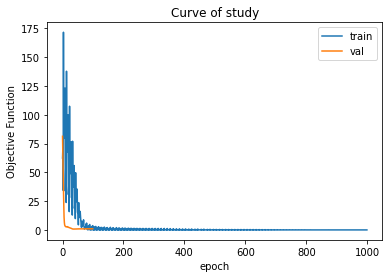

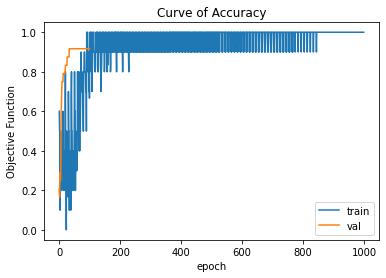

In [14]:
# 計算グラフの実行
with tf.Session() as sess: # データを入力して計算ため、Sessionオブジェクトを作成
    sess.run(init)
    loss_list = []
    val_loss_list = []
    acc_list = []
    val_acc_list = []
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int64) # ミニバッチがバッチサイズ以下は切り捨て
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y}) # ミニバッチで取得した学習データを最適化（勾配降下法適用）する。
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y}) # 学習データにおける損失およびaccuracyを計算する。
            total_loss += loss
            loss_list.append(loss)
            acc_list.append(acc)
        total_loss /= n_samples
        val_loss, acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val}) # 検証データにおける損失およびaccuracyを計算する。
        val_loss_list.append(val_loss)
        val_acc_list.append(acc)
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}".format(epoch, total_loss, val_loss, acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))

    # 学習曲線のグラフ表示
    plt.title("Curve of study")
    plt.xlabel("epoch")
    plt.ylabel("Objective Function")
    plt.plot(loss_list, label="train")
    plt.plot(val_loss_list, label="val")
    plt.legend()
    plt.show()

    # Accuracyの推移
    plt.title("Curve of Accuracy")
    plt.xlabel("epoch")
    plt.ylabel("Objective Function")
    plt.plot(acc_list, label="train")
    plt.plot(val_acc_list, label="val")
    plt.legend()
    plt.show()    

### 【問題4】House Pricesのモデルを作成

参考文献　https://qiita.com/MahoTakara/items/0d7284774c2adf1f05ec　

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
DATA_DIR='/content/drive/My Drive/'
data = pd.read_csv(f'{DATA_DIR}train.csv')

In [44]:
lendata = len(data)
col_names = data.columns
for col_name in col_names:
  missing_num = sum(pd.isnull(data[col_name]))
  print('{} : missing {} , missing_ratio {:.1f}%'.format(col_name, missing_num , missing_num / lendata * 100))

Id : missing 0 , missing_ratio 0.0%
MSSubClass : missing 0 , missing_ratio 0.0%
MSZoning : missing 0 , missing_ratio 0.0%
LotFrontage : missing 259 , missing_ratio 17.7%
LotArea : missing 0 , missing_ratio 0.0%
Street : missing 0 , missing_ratio 0.0%
Alley : missing 1369 , missing_ratio 93.8%
LotShape : missing 0 , missing_ratio 0.0%
LandContour : missing 0 , missing_ratio 0.0%
Utilities : missing 0 , missing_ratio 0.0%
LotConfig : missing 0 , missing_ratio 0.0%
LandSlope : missing 0 , missing_ratio 0.0%
Neighborhood : missing 0 , missing_ratio 0.0%
Condition1 : missing 0 , missing_ratio 0.0%
Condition2 : missing 0 , missing_ratio 0.0%
BldgType : missing 0 , missing_ratio 0.0%
HouseStyle : missing 0 , missing_ratio 0.0%
OverallQual : missing 0 , missing_ratio 0.0%
OverallCond : missing 0 , missing_ratio 0.0%
YearBuilt : missing 0 , missing_ratio 0.0%
YearRemodAdd : missing 0 , missing_ratio 0.0%
RoofStyle : missing 0 , missing_ratio 0.0%
RoofMatl : missing 0 , missing_ratio 0.0%
Exteri

In [45]:
data=data.dropna(thresh=lendata-4, axis=1)
data = data.dropna(how='any')

In [46]:
col_names = data.columns
for col_name in col_names:
  missing_num = sum(pd.isnull(data[col_name]))
  print('{} : missing {} , missing_ratio {:.1f}%'.format(col_name, missing_num , missing_num / lendata * 100))

Id : missing 0 , missing_ratio 0.0%
MSSubClass : missing 0 , missing_ratio 0.0%
MSZoning : missing 0 , missing_ratio 0.0%
LotArea : missing 0 , missing_ratio 0.0%
Street : missing 0 , missing_ratio 0.0%
LotShape : missing 0 , missing_ratio 0.0%
LandContour : missing 0 , missing_ratio 0.0%
Utilities : missing 0 , missing_ratio 0.0%
LotConfig : missing 0 , missing_ratio 0.0%
LandSlope : missing 0 , missing_ratio 0.0%
Neighborhood : missing 0 , missing_ratio 0.0%
Condition1 : missing 0 , missing_ratio 0.0%
Condition2 : missing 0 , missing_ratio 0.0%
BldgType : missing 0 , missing_ratio 0.0%
HouseStyle : missing 0 , missing_ratio 0.0%
OverallQual : missing 0 , missing_ratio 0.0%
OverallCond : missing 0 , missing_ratio 0.0%
YearBuilt : missing 0 , missing_ratio 0.0%
YearRemodAdd : missing 0 , missing_ratio 0.0%
RoofStyle : missing 0 , missing_ratio 0.0%
RoofMatl : missing 0 , missing_ratio 0.0%
Exterior1st : missing 0 , missing_ratio 0.0%
Exterior2nd : missing 0 , missing_ratio 0.0%
ExterQu

In [47]:
data.describe()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,730.054832,56.881426,10517.363948,6.100069,5.575737,1971.244003,1984.850583,443.943797,46.581220,567.366004,1057.891021,1162.906785,346.791638,5.848526,1515.546950,0.425634,0.057574,1.564770,0.382454,2.866347,1.046607,6.517478,0.613434,1.766964,473.030158,94.240576,46.692255,21.969157,3.411926,15.071282,2.760795,43.518849,6.322824,2007.815627,180930.394791
std,421.411181,42.310746,9984.666267,1.383171,1.113079,30.199555,20.644343,456.106417,161.369977,441.992392,438.500975,386.572089,436.610637,48.639512,525.650927,0.518969,0.238830,0.550987,0.502798,0.816050,0.220410,1.625902,0.644687,0.747546,213.869604,125.381679,66.267472,61.137400,29.327247,55.775138,40.191018,496.291826,2.704331,1.328542,79468.964025
min,1.000000,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.500000,20.000000,7549.000000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,223.000000,796.000000,882.000000,0.000000,0.000000,1129.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1.000000,333.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129950.000000
50%,730.000000,50.000000,9477.000000,6.000000,5.000000,1973.000000,1994.000000,384.000000,0.000000,479.000000,992.000000,1088.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1094.500000,70.000000,11603.000000,7.000000,6.000000,2000.000000,2004.000000,712.500000,0.000000,808.000000,1298.500000,1391.500000,728.000000,0.000000,1777.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [48]:
X = pd.DataFrame(data=data, columns=['GrLivArea','YearBuilt'])
y = pd.DataFrame(data=data, columns=['SalePrice'])
# NumPy 配列に変換
X = np.array(X)
y = np.array(y)

In [49]:
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [50]:
class GetMiniBatch:

    def __init__(self, X, y, batch_size = 10, seed=0):

        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):

        return self._stop

    def __getitem__(self,item):

        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size

        return self.X[p0:p1], self.y[p0:p1]  

    def __iter__(self):

        self._counter = 0

        return self

    def __next__(self):

        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1

        return self.X[p0:p1], self.y[p0:p1]

In [51]:
# ハイパーパラメータの設定
learning_rate = 0.001
batch_size = 10
num_epochs = 100
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_val_samples = X_val.shape[0]
n_test_samples = X_test.shape[0]
n_classes = 1
# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])
# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

In [52]:
def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """
    tf.random.set_random_seed(0)
    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])), # 行列（2 * 50）
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])), # 行列（50 * 100）
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes])) # 行列（100 * 1)
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])), # 第一隠れ層のバイアス
        'b2': tf.Variable(tf.random_normal([n_hidden2])), # 第二隠れ層のバイアス
        'b3': tf.Variable(tf.random_normal([n_classes])) # 出力層のバイアス
    }
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1']) # 第一隠れ層の行列積およびバイアスの加算
    layer_1 = tf.nn.relu(layer_1)                               # 活性化関数（relu）の実行
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2']) # 第二隠れ層の行列積およびバイアスの加算
    layer_2 = tf.nn.relu(layer_2)                               # 活性化関数（relu）の実行
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である　出力層の行列積およびバイアスの加算
    return layer_output                                         # 予測値（Yhat）を返す

In [53]:
# ネットワーク構造の読み込み                               
logits = example_net(X)
# 目的関数
loss_op = tf.reduce_sum(tf.square(logits-Y)) # 損失関数は予測値と実測値の最小二乗誤差を取るものとする
# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) # 最適化手法：Adam
train_op = optimizer.minimize(loss_op) 
# variableの初期化
init = tf.global_variables_initializer()

Epoch 0, loss : 14443.6625, val_loss : 5570.0092
Epoch 1, loss : 6250.5419, val_loss : 4203.5099
Epoch 2, loss : 5688.6317, val_loss : 4005.4132
Epoch 3, loss : 5479.6351, val_loss : 3877.9806
Epoch 4, loss : 5355.6832, val_loss : 3833.6299
Epoch 5, loss : 5332.7077, val_loss : 3828.3621
Epoch 6, loss : 5328.9140, val_loss : 3831.6775
Epoch 7, loss : 5328.6819, val_loss : 3836.3291
Epoch 8, loss : 5328.4650, val_loss : 3838.0636
Epoch 9, loss : 5327.9240, val_loss : 3842.3226
Epoch 10, loss : 5327.4450, val_loss : 3847.2711
Epoch 11, loss : 5326.9209, val_loss : 3851.1077
Epoch 12, loss : 5326.4807, val_loss : 3854.8476
Epoch 13, loss : 5326.1973, val_loss : 3858.6684
Epoch 14, loss : 5325.7402, val_loss : 3861.8693
Epoch 15, loss : 5325.4352, val_loss : 3864.8900
Epoch 16, loss : 5325.0823, val_loss : 3867.0826
Epoch 17, loss : 5324.7102, val_loss : 3870.4190
Epoch 18, loss : 5324.7010, val_loss : 3871.8233
Epoch 19, loss : 5324.3080, val_loss : 3874.3574
Epoch 20, loss : 5324.1139, v

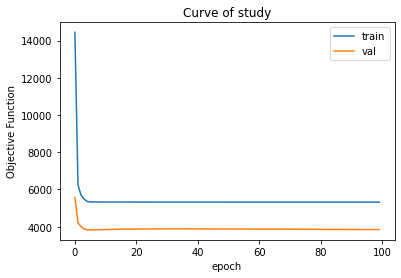

In [56]:
# 計算グラフの実行
with tf.Session() as sess: # データを入力して計算ため、Sessionオブジェクトを作成
    sess.run(init)
    loss_list = []
    val_loss_list = []
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int64) # ミニバッチがバッチサイズ以下は切り捨て
        total_loss = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y}) # ミニバッチで取得した学習データを最適化（勾配降下法適用）する。
            loss = sess.run(loss_op, feed_dict={X: mini_batch_x, Y: mini_batch_y}) # 学習データにおける損失を計算する。
            total_loss += math.sqrt(loss) / batch_size
        total_loss /= n_samples
        loss_list.append(total_loss)
        val_loss = sess.run(loss_op, feed_dict={X: X_val, Y: y_val}) # 検証データにおける損失を計算する。
        val_loss = math.sqrt(val_loss) / n_val_samples
        val_loss_list.append(val_loss)
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}".format(epoch, total_loss, val_loss))
    n_samples = X_test.shape[0]
    test_loss = sess.run(loss_op, feed_dict={X: X_test, Y: y_test}) # 検証データにおける損失を計算する。
    test_loss = math.sqrt(test_loss) / n_test_samples
    print("test_loss : {:.4f}".format(test_loss))

    # 学習曲線のグラフ表示
    plt.title("Curve of study")
    plt.xlabel("epoch")
    plt.ylabel("Objective Function")
    plt.plot(loss_list, label="train")
    plt.plot(val_loss_list, label="val")
    plt.legend()
    plt.show()

### 【問題5】MNISTのモデルを作成

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [58]:
from sklearn.preprocessing import OneHotEncoder

In [59]:
# データセットを取り込むコード
X_train = np.load("/content/drive/My Drive/X_train.npy")
y_train = np.load("/content/drive/My Drive/y_train.npy")
X_test = np.load("/content/drive/My Drive/X_test.npy")
y_test = np.load("/content/drive/My Drive/y_test.npy")
y_train = (y_train.reshape(-1,1) == np.arange(10)).astype(np.float64)
y_test = (y_test.reshape(-1,1) == np.arange(10)).astype(np.float64)
print(y_train.shape)
print(y_test.shape)

(60000, 10)
(10000, 10)


In [60]:
# データセットの確認
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000, 10)
(10000, 28, 28)
(10000, 10)


In [61]:
# 平滑化
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

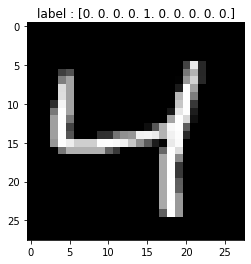

In [62]:
# 画像データの可視化
import matplotlib.pyplot as plt
%matplotlib inline
index = 2
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

In [63]:
# 前処理
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [64]:
y_train_one_hot = (y_train.reshape(-1,1) == np.arange(10)).astype(np.float64)
y_test_one_hot = (y_test.reshape(-1,1) == np.arange(10)).astype(np.float64)
print(y_train.shape)
print(y_train_one_hot.shape)
print(y_train_one_hot.dtype)

(60000, 10)
(600000, 10)
float64


In [65]:
def split_data(X, permutation, val_size_rate=0.2):
    X = X[permutation]
    val_size = int(len(X) * val_size_rate)
    val = X[:val_size]
    train = X[val_size:]
    return train, val

permutation = np.random.permutation(np.arange(len(X_train)))
X_train, X_val = split_data(X_train, permutation)
y_train, y_val = split_data(y_train_one_hot, permutation)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(48000, 784)
(48000, 10)
(12000, 784)
(12000, 10)


In [66]:
class GetMiniBatch:

    def __init__(self, X, y, batch_size = 10, seed=0):

        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):

        return self._stop

    def __getitem__(self,item):

        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size

        return self.X[p0:p1], self.y[p0:p1]  

    def __iter__(self):

        self._counter = 0

        return self

    def __next__(self):

        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1

        return self.X[p0:p1], self.y[p0:p1]

In [67]:
# ハイパーパラメータの設定
learning_rate = 0.001 # 学習率
batch_size = 10 # バッチサイズ
num_epochs = 10 # エポック数
n_hidden1 = 400 # 第一隠れ層のノード数
n_hidden2 = 200 # 第二隠れ層ノードの数
n_input = X_train.shape[1] # 入力層のノード数（特徴量の数）
n_samples = X_train.shape[0] # サンプル数
n_classes = 10 # 出力層のノード数

# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input]) # 学習データをTensorFlowのデータフローグラフに入力ための placeholder を用意
Y = tf.placeholder("float", [None, n_classes]) # 学習データをTensorFlowのデータフローグラフに入力ための placeholder を用意
    
# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

In [68]:
# ネットワーク構造の読み込み                               
logits = example_net(X)
# 目的関数
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=logits)) # sigmoid → softmaxに変更してみた
# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) # 最適化手法：Adam
train_op = optimizer.minimize(loss_op) 
# 推定結果
correct_pred = tf.equal(tf.argmax(Y, axis=1), tf.argmax(logits, axis=1) )
# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
# variableの初期化
init = tf.global_variables_initializer()

In [69]:
def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """
    tf.random.set_random_seed(0)
    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])), # 行列（4 * 50）
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])), # 行列（50 * 100）
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes])) # 行列（100 * 3)
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])), # 第一隠れ層のバイアス
        'b2': tf.Variable(tf.random_normal([n_hidden2])), # 第二隠れ層のバイアス
        'b3': tf.Variable(tf.random_normal([n_classes])) # 出力層のバイアス
    }
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1']) # 第一隠れ層の行列積およびバイアスの加算
    layer_1 = tf.nn.relu(layer_1)                               # 活性化関数（relu）の実行
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2']) # 第二隠れ層の行列積およびバイアスの加算
    layer_2 = tf.nn.relu(layer_2)                               # 活性化関数（relu）の実行
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である　出力層の行列積およびバイアスの加算
    return layer_output                                         # 予測値（Yhat）を返す

Epoch 0, loss : 6.5655, val_loss : 35.9178, acc : 0.804
Epoch 1, loss : 1.8911, val_loss : 17.9288, acc : 0.813
Epoch 2, loss : 0.7754, val_loss : 12.3666, acc : 0.743
Epoch 3, loss : 0.3857, val_loss : 8.9478, acc : 0.765
Epoch 4, loss : 0.2240, val_loss : 7.0799, acc : 0.795
Epoch 5, loss : 0.1392, val_loss : 6.5023, acc : 0.765
Epoch 6, loss : 0.0958, val_loss : 6.7349, acc : 0.745
Epoch 7, loss : 0.0738, val_loss : 5.9202, acc : 0.774
Epoch 8, loss : 0.0545, val_loss : 5.2676, acc : 0.821
Epoch 9, loss : 0.0427, val_loss : 6.9753, acc : 0.687
test_acc : 0.103


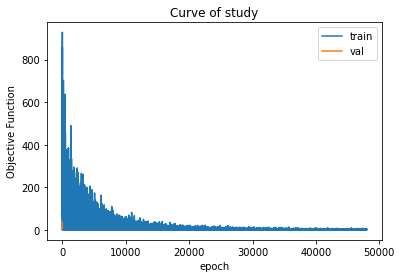

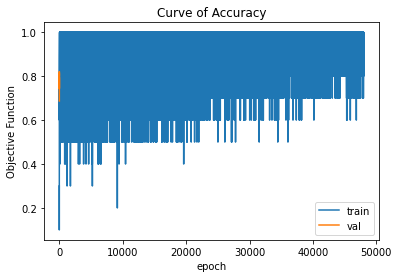

In [70]:
# 計算グラフの実行
with tf.Session() as sess: # データを入力して計算ため、Sessionオブジェクトを作成
    sess.run(init)
    loss_list = []
    val_loss_list = []
    acc_list = []
    val_acc_list = []
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int64) # ミニバッチがバッチサイズ以下は切り捨て
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y}) # ミニバッチで取得した学習データを最適化（勾配降下法適用）する。
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y}) # 学習データにおける損失およびaccuracyを計算する。
            total_loss += loss
            loss_list.append(loss)
            acc_list.append(acc)
        total_loss /= n_samples
        val_loss, acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val}) # 検証データにおける損失およびaccuracyを計算する。
        val_loss_list.append(val_loss)
        val_acc_list.append(acc)
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}".format(epoch, total_loss, val_loss, acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))

    # 学習曲線のグラフ表示
    plt.title("Curve of study")
    plt.xlabel("epoch")
    plt.ylabel("Objective Function")
    plt.plot(loss_list, label="train")
    plt.plot(val_loss_list, label="val")
    plt.legend()
    plt.show()

    # Accuracyの推移
    plt.title("Curve of Accuracy")
    plt.xlabel("epoch")
    plt.ylabel("Objective Function")
    plt.plot(acc_list, label="train")
    plt.plot(val_acc_list, label="val")
    plt.legend()
    plt.show()   